In [1]:
import os
import gc
import json
import unidecode
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset

import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import VGG19_Weights

import optuna
import wandb
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from datetime import datetime

import import_ipynb

######## 

from DATA_AND_MODELS import VanGoghDataset,VanGoghModel

wandb.login(key='ba8ed449ca151ad3f490026aec87d75b7171a16d')


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/gabriel/.netrc
wandb: Currently logged in as: gabi-dadashev (gabi-dadashev-tel-aviv-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
def early_stop_check(patience, best_val_loss, best_val_loss_epoch, current_val_loss, current_val_loss_epoch):
    early_stop_flag = False  
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        best_val_loss_epoch = current_val_loss_epoch
    else:
        if current_val_loss_epoch - best_val_loss_epoch > patience:
            early_stop_flag = True  
    return best_val_loss, best_val_loss_epoch, early_stop_flag


In [3]:
def train_model_with_hyperparams(model, train_loader, val_loader, optimizer, criterion, epochs, patience):
    print('train_model_with_hyperparams')
    
    best_val_loss = float('inf')
    best_val_loss_epoch = 0  
    early_stop_flag = False
    best_model_state = None  

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    val_f1s = []
    val_aucs = []

    for epoch in range(1, epochs + 1):
        
        ### Training Loop
        model.train() 
        epoch_train_loss = 0.0 
        total_train_samples = 0 
        correct_train_predictions = 0 
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad() 
            
            outputs = model(inputs).squeeze(1)  
            loss = criterion(outputs.view(-1), labels)
            loss.backward() 
            optimizer.step()  

            epoch_train_loss += loss.item() * inputs.size(0)
            total_train_samples += inputs.size(0)
            
            preds_train = (outputs > 0.5).float()
            correct_train_predictions += (preds_train == labels).sum().item()

        epoch_train_loss /= total_train_samples
        train_accuracy = correct_train_predictions / total_train_samples

        ### Validation Loop
        model.eval()  
        epoch_val_loss = 0.0 
        total_val_samples = 0 
        correct_val_predictions = 0

        all_val_labels = []
        all_val_preds = []
        all_val_probs = []

        with torch.no_grad(): 
            for inputs, labels in val_loader: 
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze(1)  # outputs shape: (batch_size)
                loss = criterion(outputs.view(-1), labels)

                epoch_val_loss += loss.item() * inputs.size(0)
                total_val_samples += inputs.size(0)
                
                preds = (outputs > 0.5).float()
                
                correct_val_predictions += (preds == labels).sum().item()

                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(preds.cpu().numpy())
                all_val_probs.extend(outputs.cpu().numpy())

        epoch_val_loss /= total_val_samples
        val_accuracy = correct_val_predictions / total_val_samples

        if len(np.unique(all_val_labels)) > 1:
            val_f1 = f1_score(all_val_labels, all_val_preds)
            val_auc = roc_auc_score(all_val_labels, all_val_probs)
        else:
            val_f1 = 0
            val_auc = 0

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        val_f1s.append(val_f1)
        val_aucs.append(val_auc)

        best_val_loss, best_val_loss_epoch, early_stop_flag = early_stop_check(patience, best_val_loss, best_val_loss_epoch, epoch_val_loss, epoch)
        if epoch_val_loss == best_val_loss:
            best_model_state = model.state_dict()

        print(f"Epoch {epoch}: Train Loss = {epoch_train_loss:.4f}, Val Loss = {epoch_val_loss:.4f}, Train Acc = {train_accuracy:.4f}, Val Acc = {val_accuracy:.4f}, Val F1 = {val_f1:.4f}, Val AUC = {val_auc:.4f}")

        if early_stop_flag: 
            break 

    if best_model_state is not None: 
        now = datetime.now()
        torch.save(best_model_state, f"best_model_trial_{now.strftime('%H:%M:%S')}.pt") 

    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
    plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, val_f1s, label="Validation F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("Validation F1 Score")
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, val_aucs, label="Validation AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.title("Validation AUC")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return best_val_loss


In [4]:
classes = pd.read_csv("classes.csv", encoding="utf-8")
classes=classes[['filename', 'artist', 'genre', 'description', 'phash', 'width','height', 'genre_count']].copy()
classes_only_post_impressionism = classes[classes["filename"].str.contains('Post_Impressionism', case=False, na=False)].copy()
classes_only_post_impressionism['is_van_gogh'] = np.where(classes_only_post_impressionism['artist'] == 'vincent van gogh', 1, 0)
classes_only_post_impressionism=classes_only_post_impressionism.reset_index(drop=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 


In [5]:
dataset = VanGoghDataset(dataframe=classes_only_post_impressionism)

model_VGG19 = VanGoghModel(device,None,'VGG19').model
model_Alex = VanGoghModel(device,None,'AlexNet').model

***Train VGG19***

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


--- Fold 1/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6946, Val Loss = 0.6929, Train Acc = 0.8381, Val Acc = 0.8487, Val F1 = 0.0000, Val AUC = 0.6771
Epoch 2: Train Loss = 0.6843, Val Loss = 0.6813, Train Acc = 0.8688, Val Acc = 0.8859, Val F1 = 0.4627, Val AUC = 0.8492
Epoch 3: Train Loss = 0.6785, Val Loss = 0.6784, Train Acc = 0.8852, Val Acc = 0.8946, Val F1 = 0.5233, Val AUC = 0.8820


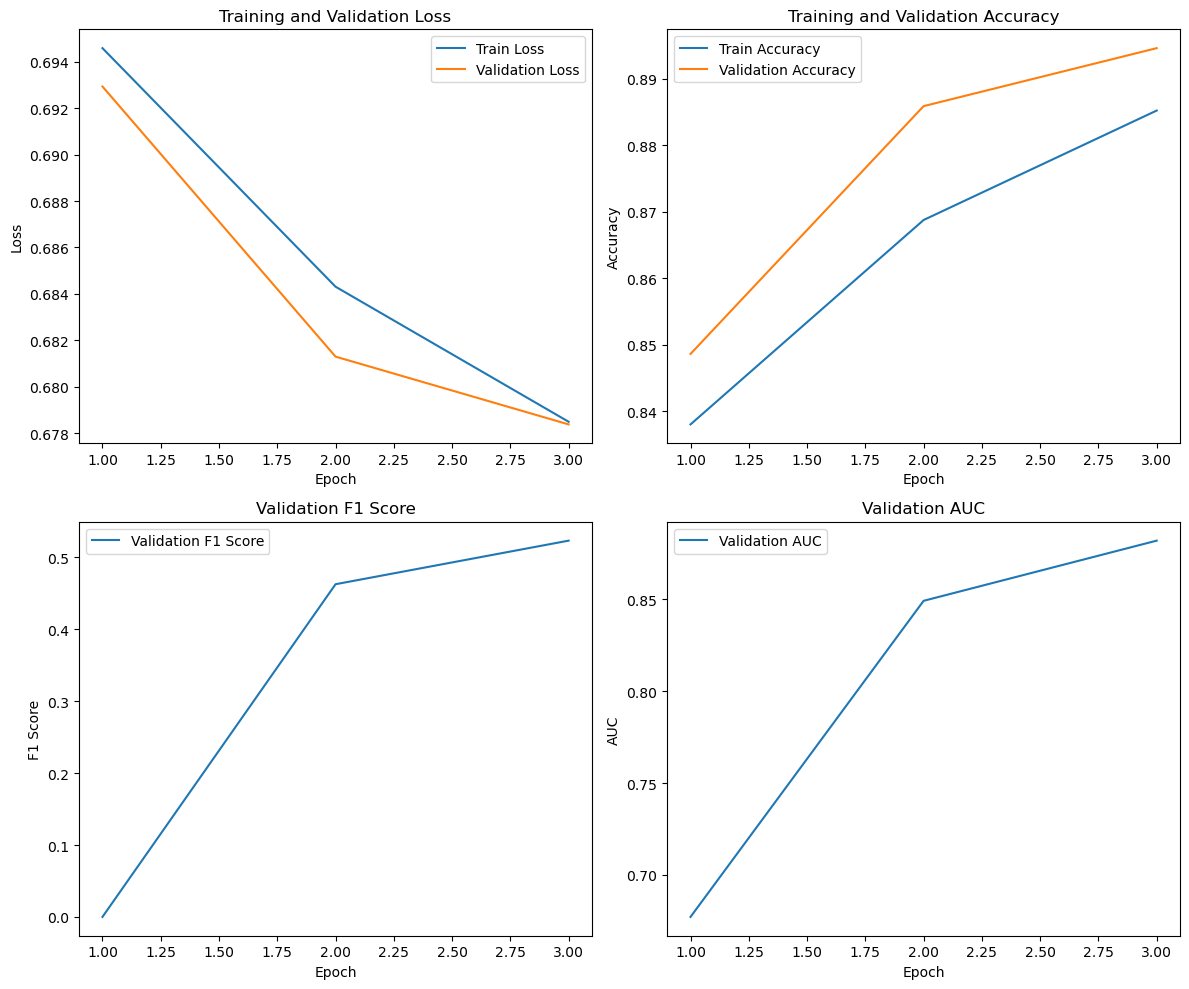

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.67837
fold,1
val_accuracy,0.88748
val_auc,0.87522
val_f1,0.48921


--- Fold 2/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6775, Val Loss = 0.7069, Train Acc = 0.8916, Val Acc = 0.8574, Val F1 = 0.6484, Val AUC = 0.8886
Epoch 2: Train Loss = 0.6753, Val Loss = 0.6829, Train Acc = 0.8995, Val Acc = 0.8574, Val F1 = 0.2857, Val AUC = 0.8489
Epoch 3: Train Loss = 0.6751, Val Loss = 0.6724, Train Acc = 0.9021, Val Acc = 0.8851, Val F1 = 0.5051, Val AUC = 0.8797


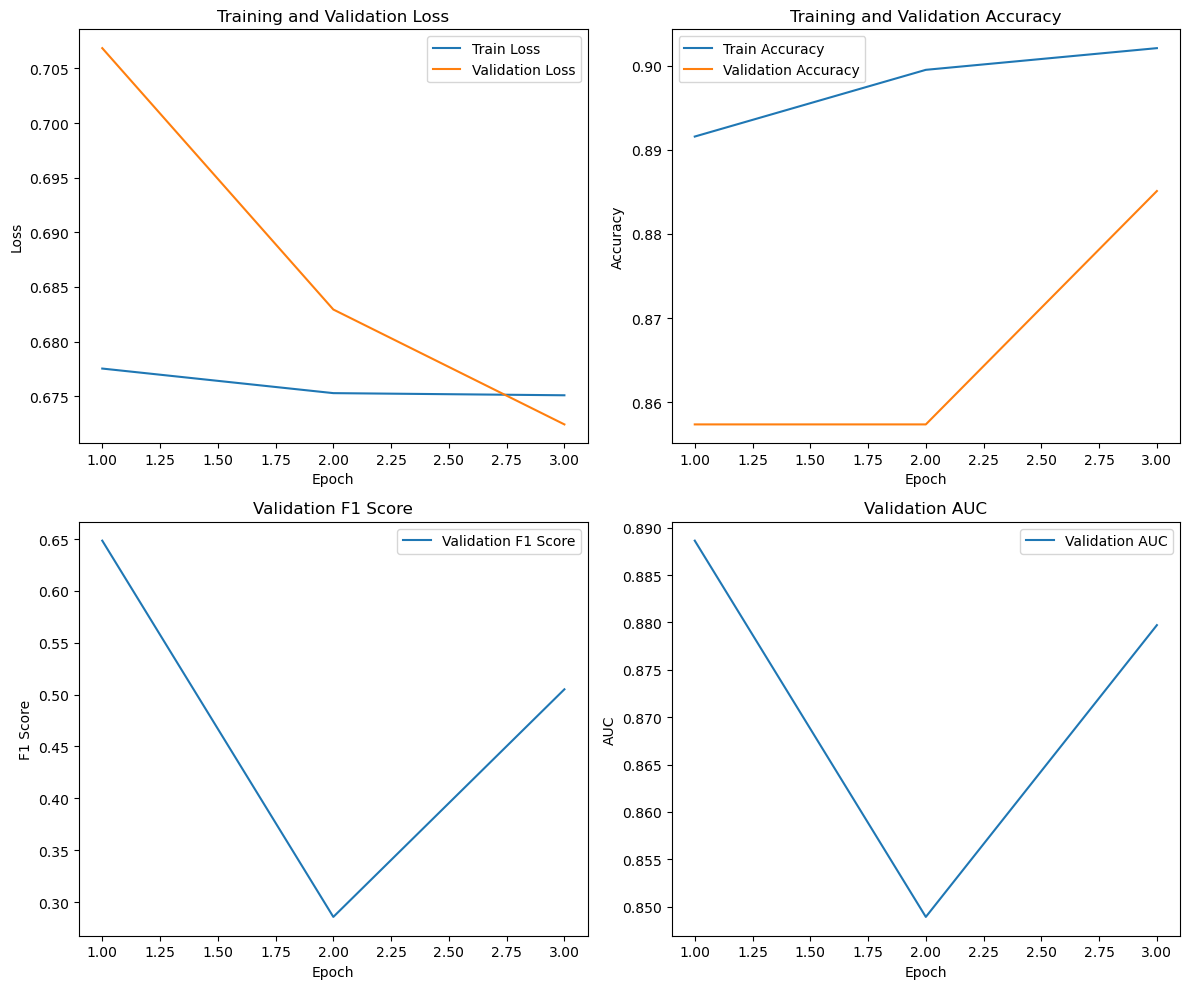

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.67241
fold,2
val_accuracy,0.88035
val_auc,0.90025
val_f1,0.4811


--- Fold 3/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6747, Val Loss = 0.6680, Train Acc = 0.8944, Val Acc = 0.9112, Val F1 = 0.6267, Val AUC = 0.9149
Epoch 2: Train Loss = 0.6750, Val Loss = 0.6700, Train Acc = 0.8932, Val Acc = 0.9072, Val F1 = 0.6087, Val AUC = 0.8882
Epoch 3: Train Loss = 0.6744, Val Loss = 0.6803, Train Acc = 0.8983, Val Acc = 0.8763, Val F1 = 0.3659, Val AUC = 0.8077


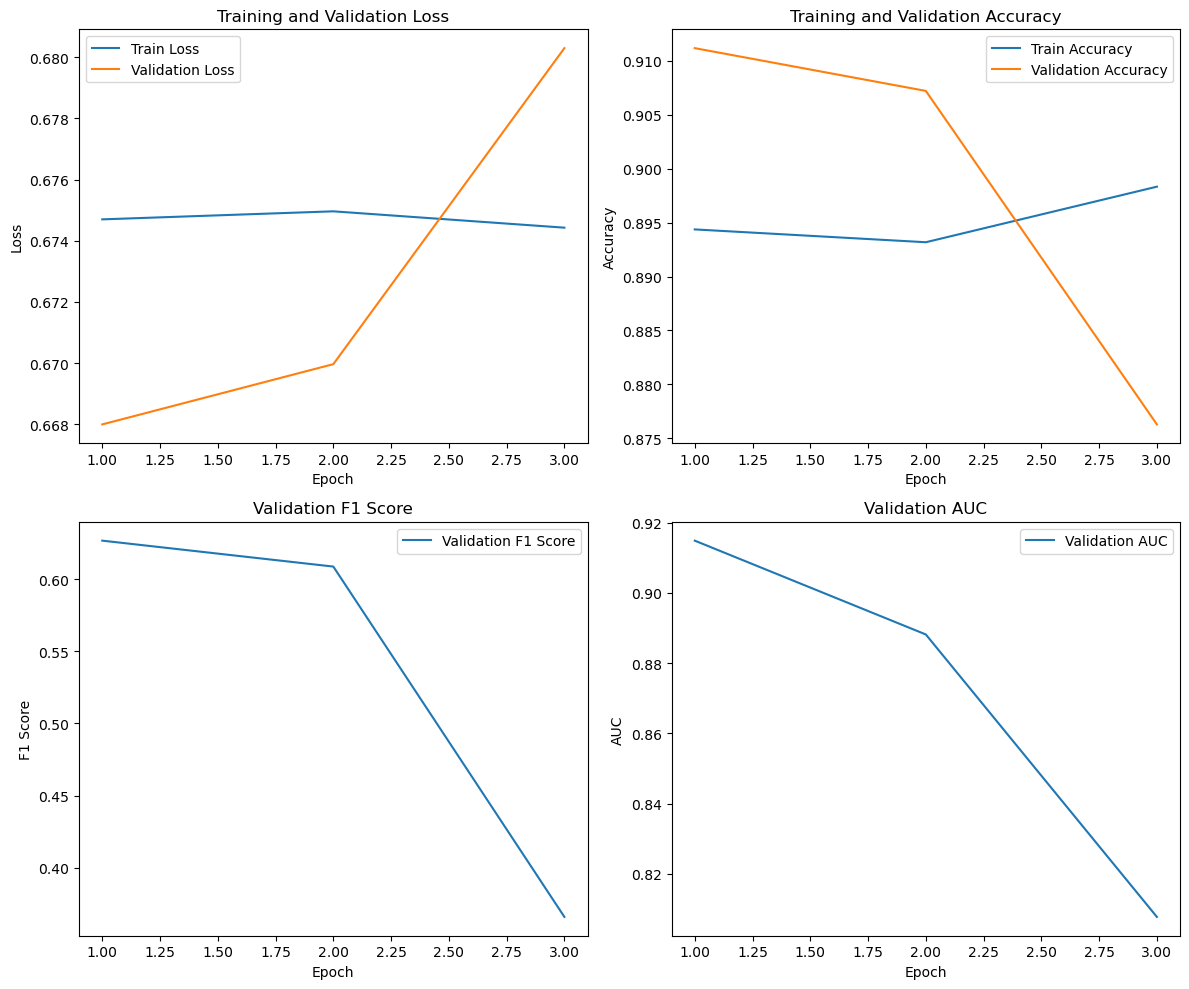

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.668
fold,3
val_accuracy,0.8755
val_auc,0.82596
val_f1,0.35918


--- Fold 4/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6754, Val Loss = 0.6810, Train Acc = 0.8898, Val Acc = 0.8747, Val F1 = 0.3525, Val AUC = 0.7690
Epoch 2: Train Loss = 0.6728, Val Loss = 0.6752, Train Acc = 0.9049, Val Acc = 0.8890, Val F1 = 0.4697, Val AUC = 0.8057
Epoch 3: Train Loss = 0.6730, Val Loss = 0.6801, Train Acc = 0.9051, Val Acc = 0.8779, Val F1 = 0.3984, Val AUC = 0.7636


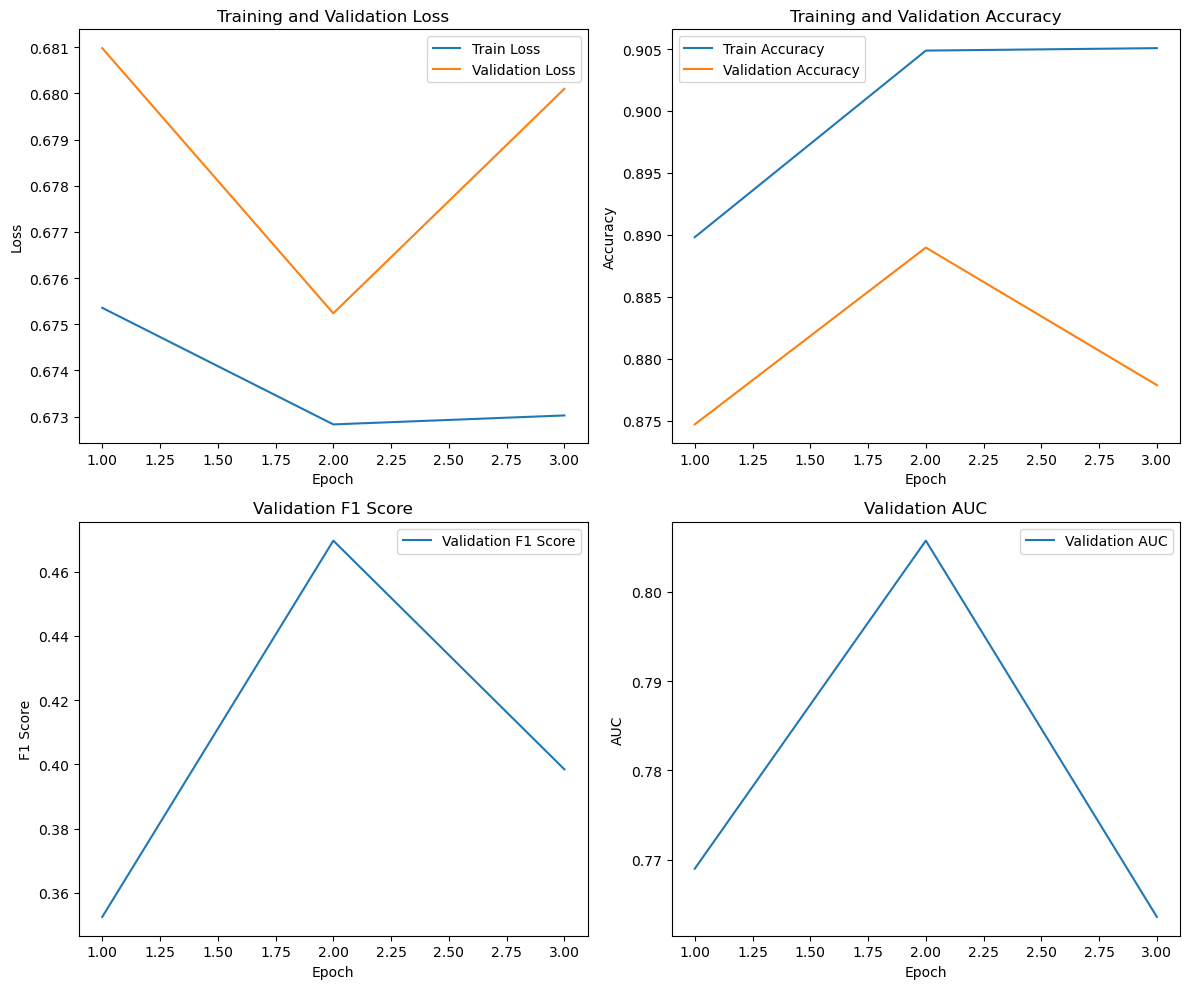

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.67524
fold,4
val_accuracy,0.87391
val_auc,0.77816
val_f1,0.35102


--- Fold 5/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6706, Val Loss = 0.6644, Train Acc = 0.9090, Val Acc = 0.9262, Val F1 = 0.7257, Val AUC = 0.8947
Epoch 2: Train Loss = 0.6767, Val Loss = 0.6822, Train Acc = 0.8920, Val Acc = 0.9001, Val F1 = 0.6802, Val AUC = 0.8963
Epoch 3: Train Loss = 0.6721, Val Loss = 0.6960, Train Acc = 0.9013, Val Acc = 0.8866, Val F1 = 0.6911, Val AUC = 0.8976


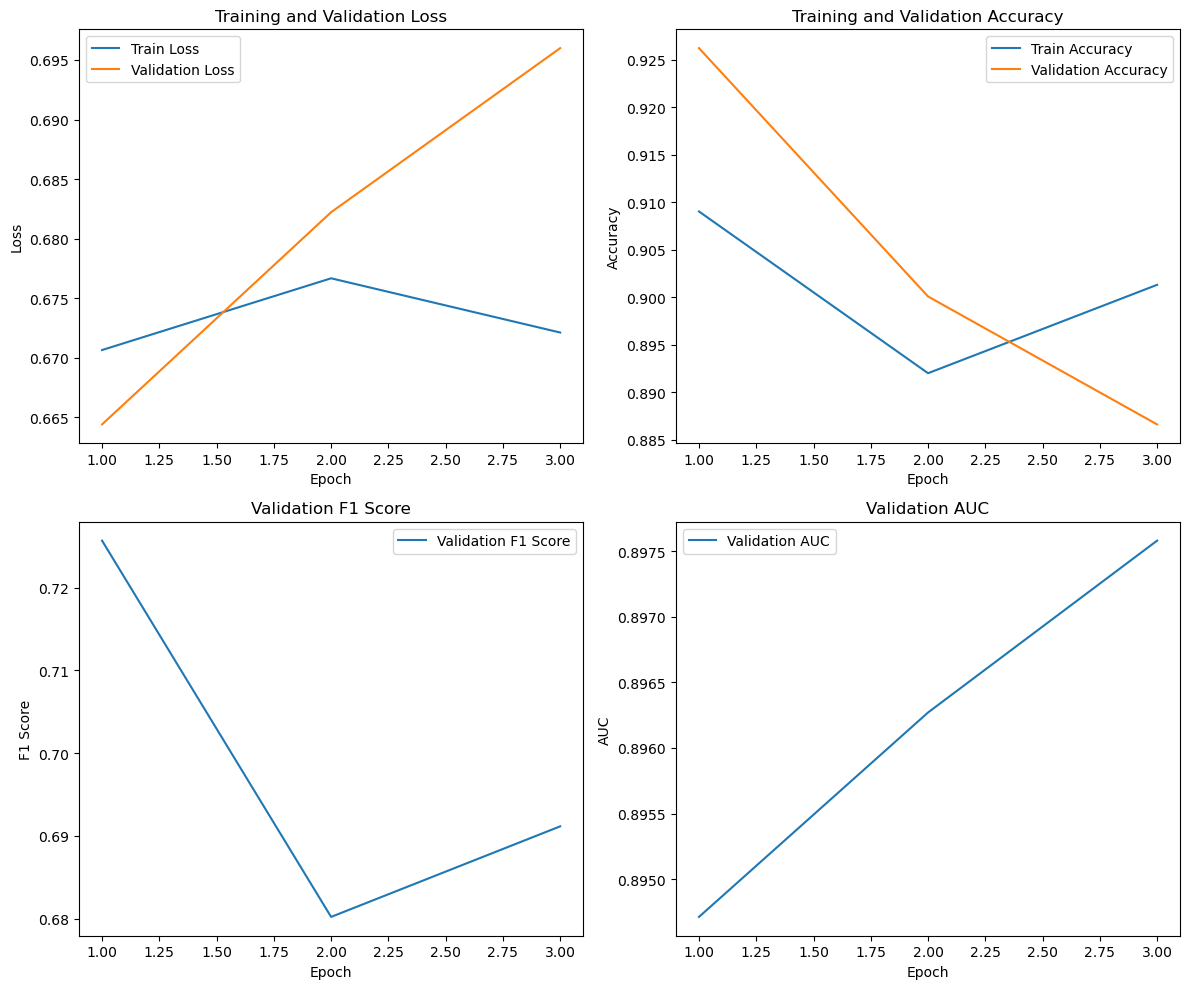

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.6644
fold,5
val_accuracy,0.88422
val_auc,0.89018
val_f1,0.69068


In [6]:
patience = 2
k_folds = 5  
epochs=4


learning_rate=0.000022012211629918463
weight_decay=0.000001549668920821374
batch_size = 4


kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_losses = []


for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    
    print(f"--- Fold {fold+1}/{k_folds} ---")

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    optimizer_VGG19 = optim.Adam(model_VGG19.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion_VGG19 = nn.BCEWithLogitsLoss()

    wandb.init(
        project="Train_VGG19",
        config={
            "model": "VGG19",  
            "learning_rate": learning_rate,
            "weight_decay": weight_decay,
            "batch_size": batch_size,
            "k_folds": k_folds,
            "epochs": epochs,      
            "patience": patience
        },
        name=f"VGG19_fold_{fold+1}"
    )

    best_val_loss_VGG19 = train_model_with_hyperparams(
        model_VGG19, train_loader, val_loader, optimizer_VGG19, criterion_VGG19,
        epochs=epochs, patience=patience
    )
    
    fold_losses.append(best_val_loss_VGG19)
    
    model_VGG19.eval()
    val_true = []
    val_pred = []
    val_probs = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_VGG19(inputs).squeeze(1)  
            probs = outputs  
            preds = (probs > 0.5).float()
    
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(preds.cpu().numpy())
            val_probs.extend(probs.cpu().numpy())

    
    acc = accuracy_score(val_true, val_pred)
    auc = roc_auc_score(val_true, val_probs)
    f1 = f1_score(val_true, val_pred)

    fold_accuracies.append(acc)
    fold_aucs.append(auc)
    fold_f1s.append(f1)


    wandb.log({
        "fold": fold+1,
        "best_val_loss_VGG19": best_val_loss_VGG19,
        "val_accuracy": acc,
        "val_auc": auc,
        "val_f1": f1
    })
    
    wandb.finish()






***Train AlexNet***

--- Fold 1/5 ---
train_model_with_hyperparams
Epoch 1: Train Loss = 0.6720, Val Loss = 0.6711, Train Acc = 0.9017, Val Acc = 0.9160, Val F1 = 0.6687, Val AUC = 0.9172
Epoch 2: Train Loss = 0.6722, Val Loss = 0.6754, Train Acc = 0.9037, Val Acc = 0.9105, Val F1 = 0.6647, Val AUC = 0.9247
Epoch 3: Train Loss = 0.6683, Val Loss = 0.6759, Train Acc = 0.9124, Val Acc = 0.8938, Val F1 = 0.4724, Val AUC = 0.9143


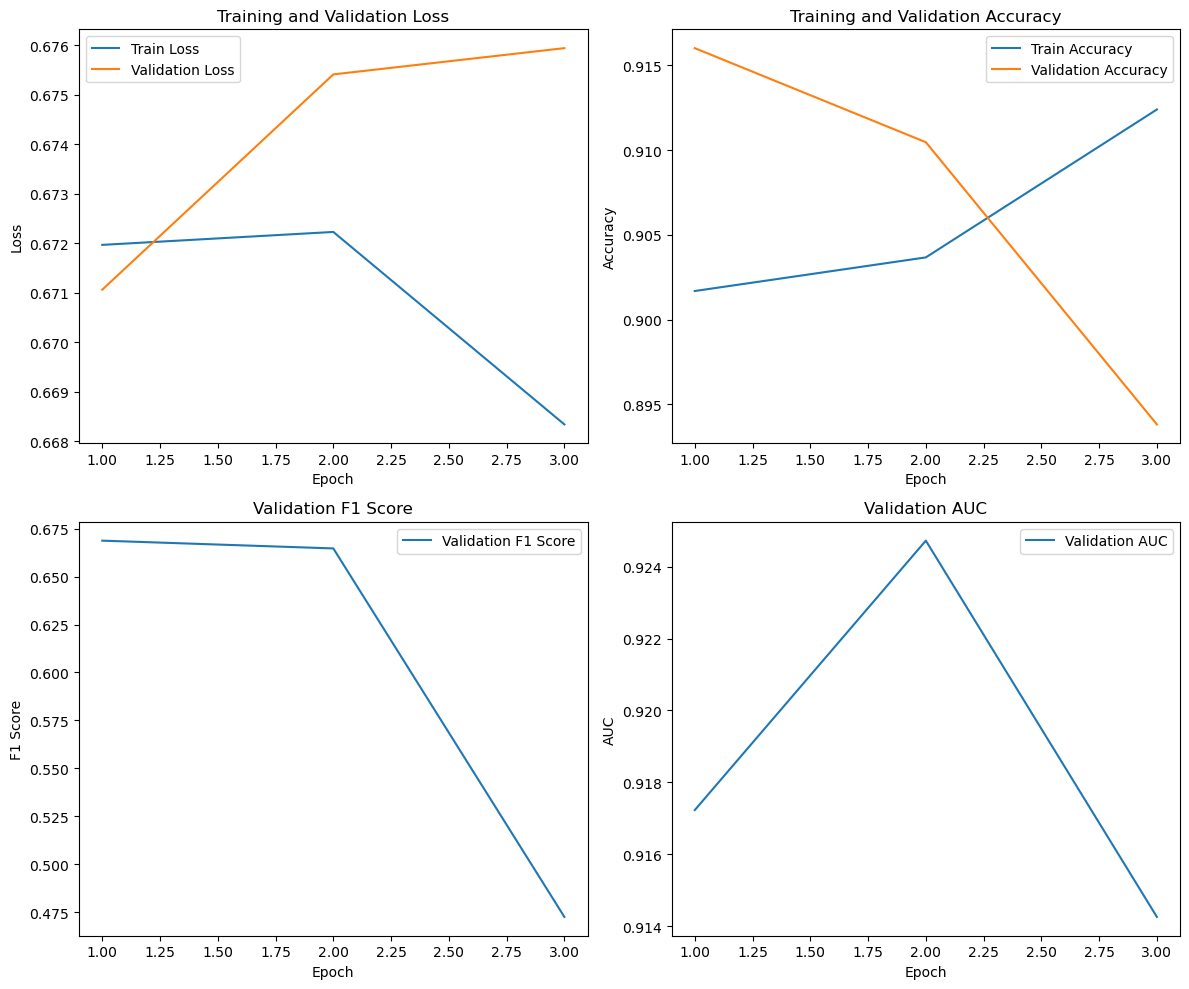

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.67107
fold,1
val_accuracy,0.8962
val_auc,0.91773
val_f1,0.49027


--- Fold 2/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6708, Val Loss = 0.6669, Train Acc = 0.9100, Val Acc = 0.9065, Val F1 = 0.6529, Val AUC = 0.9193
Epoch 2: Train Loss = 0.6699, Val Loss = 0.6667, Train Acc = 0.9110, Val Acc = 0.9105, Val F1 = 0.6835, Val AUC = 0.9033
Epoch 3: Train Loss = 0.6718, Val Loss = 0.6715, Train Acc = 0.9118, Val Acc = 0.8954, Val F1 = 0.6095, Val AUC = 0.8903


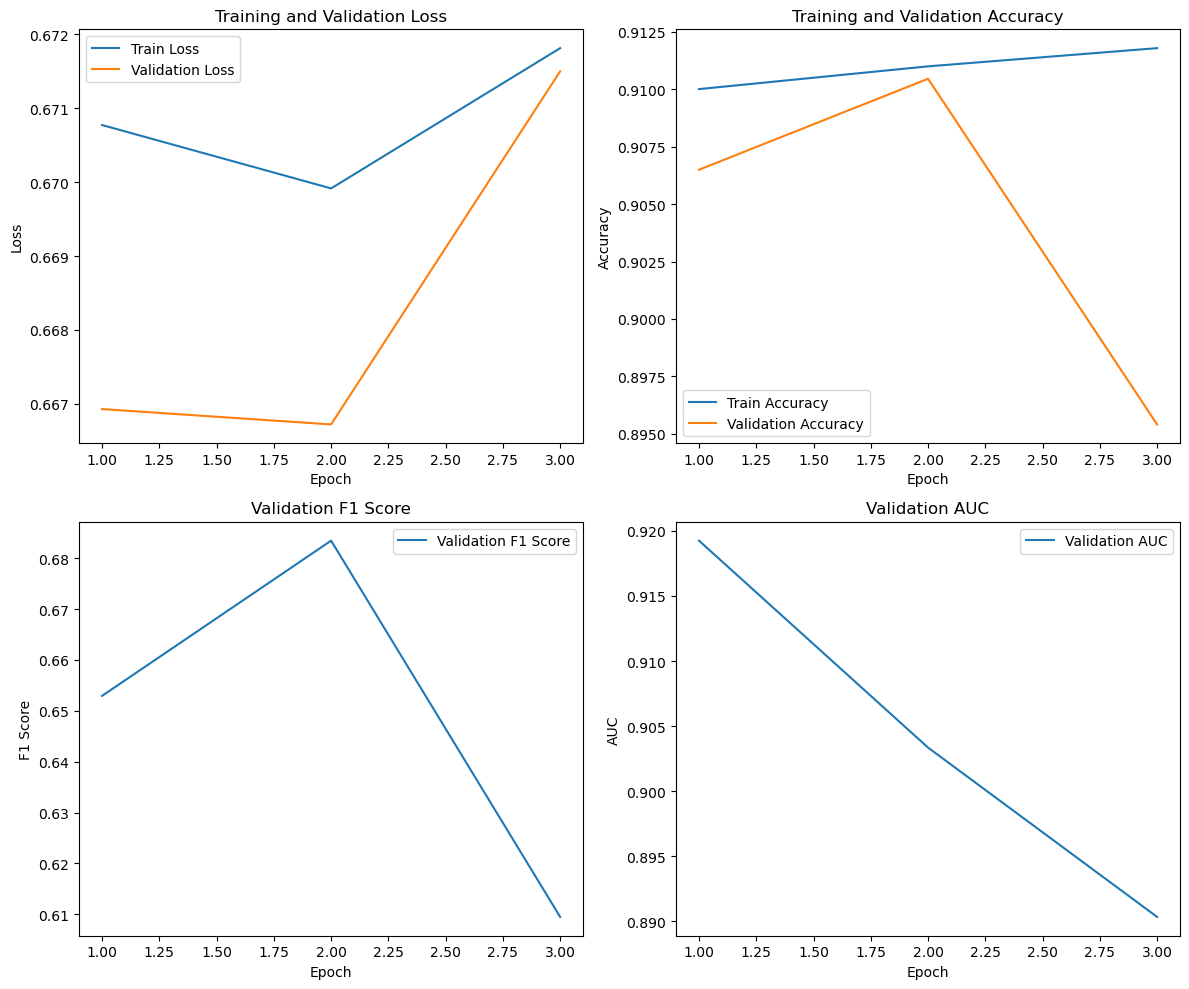

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.66672
fold,2
val_accuracy,0.90016
val_auc,0.89582
val_f1,0.625


--- Fold 3/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6693, Val Loss = 0.6669, Train Acc = 0.9116, Val Acc = 0.9159, Val F1 = 0.6603, Val AUC = 0.9368
Epoch 2: Train Loss = 0.6704, Val Loss = 0.6642, Train Acc = 0.9118, Val Acc = 0.9247, Val F1 = 0.7147, Val AUC = 0.9423
Epoch 3: Train Loss = 0.6720, Val Loss = 0.6692, Train Acc = 0.9075, Val Acc = 0.9231, Val F1 = 0.7427, Val AUC = 0.9360


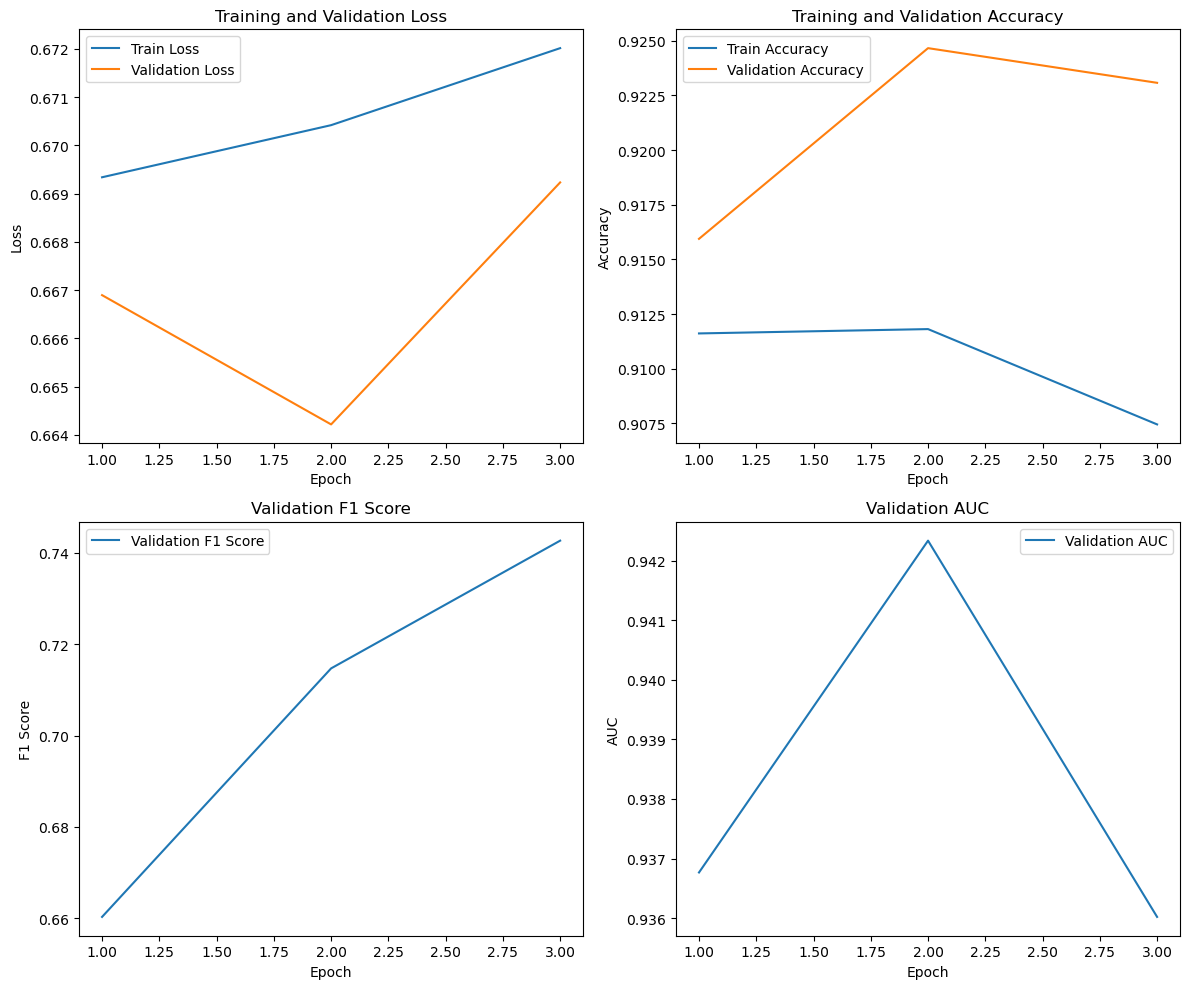

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.66422
fold,3
val_accuracy,0.93021
val_auc,0.94211
val_f1,0.76471


--- Fold 4/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6726, Val Loss = 0.6814, Train Acc = 0.9005, Val Acc = 0.8723, Val F1 = 0.3320, Val AUC = 0.8448
Epoch 2: Train Loss = 0.6708, Val Loss = 0.6675, Train Acc = 0.9067, Val Acc = 0.9167, Val F1 = 0.6828, Val AUC = 0.9156
Epoch 3: Train Loss = 0.6691, Val Loss = 0.6702, Train Acc = 0.9116, Val Acc = 0.9072, Val F1 = 0.6164, Val AUC = 0.9039


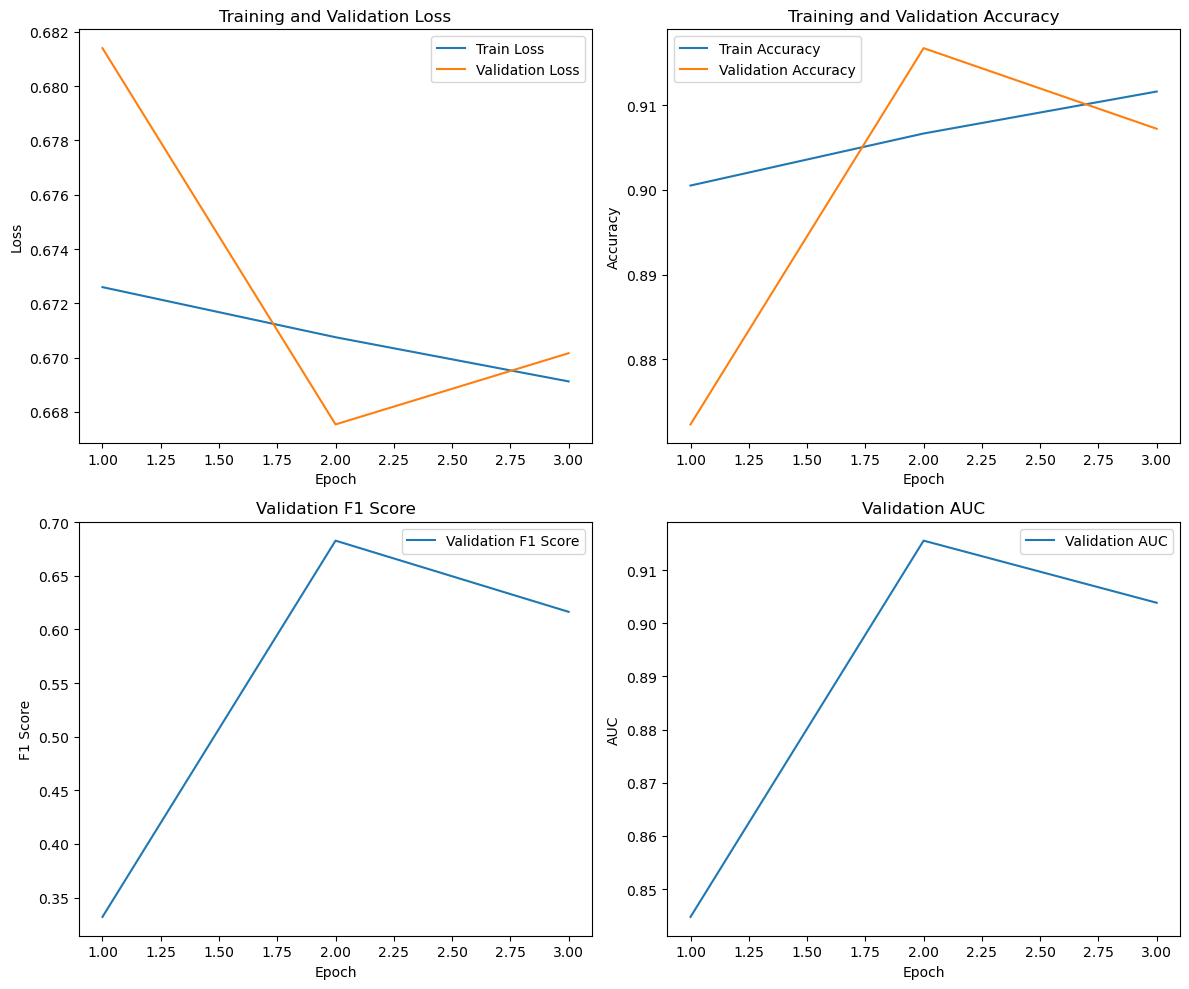

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.66754
fold,4
val_accuracy,0.90563
val_auc,0.90095
val_f1,0.60726


--- Fold 5/5 ---


train_model_with_hyperparams
Epoch 1: Train Loss = 0.6674, Val Loss = 0.6692, Train Acc = 0.9185, Val Acc = 0.9247, Val F1 = 0.7545, Val AUC = 0.9426
Epoch 2: Train Loss = 0.6680, Val Loss = 0.6647, Train Acc = 0.9150, Val Acc = 0.9215, Val F1 = 0.6877, Val AUC = 0.9222
Epoch 3: Train Loss = 0.6681, Val Loss = 0.6617, Train Acc = 0.9106, Val Acc = 0.9326, Val F1 = 0.7536, Val AUC = 0.9428


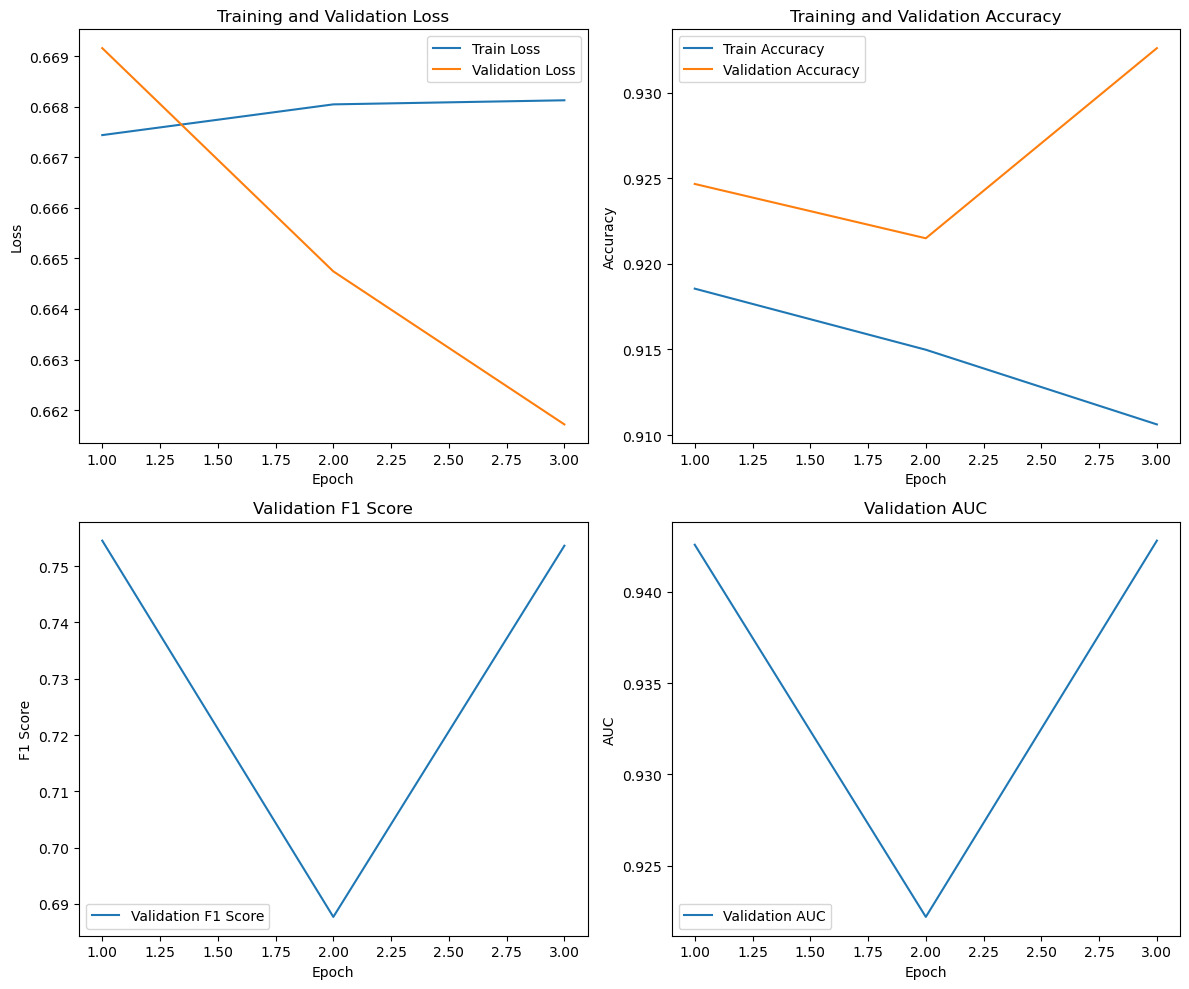

best_val_loss_VGG19,▁
fold,▁
val_accuracy,▁
val_auc,▁
val_f1,▁
best_val_loss_VGG19,0.66172
fold,5
val_accuracy,0.93101
val_auc,0.94124
val_f1,0.74487


In [8]:
patience = 2
k_folds = 5  
epochs=3

batch_size = 8
weight_decay = 1.2852718112074654e-05
learning_rate=3.020842532706549e-05


kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_losses = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    
    print(f"--- Fold {fold+1}/{k_folds} ---")

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


    optimizer_AlexNet = optim.Adam(model_Alex.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion_AlexNet = nn.BCEWithLogitsLoss()

    wandb.init(
        project="Train_AlexNet",
        config={
            "model": "AlexNet",  
            "learning_rate": learning_rate,
            "weight_decay": weight_decay,
            "batch_size": batch_size,
            "k_folds": k_folds,
            "epochs": epochs,      
            "patience": patience
        },
        name=f"Train_AlexNet{fold+1}"
    )

    best_val_loss_AlexNet = train_model_with_hyperparams(
        model_Alex, train_loader, val_loader, optimizer_AlexNet, criterion_AlexNet, epochs=epochs, patience=patience
    )

    fold_losses.append(best_val_loss_AlexNet)

 
    model_Alex.eval()
    val_true = []
    val_pred = []
    val_probs = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_Alex(inputs).squeeze(1)  
            probs = outputs  
            preds = (probs > 0.5).float()
    
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(preds.cpu().numpy())
            val_probs.extend(probs.cpu().numpy())

    acc = accuracy_score(val_true, val_pred)
    auc = roc_auc_score(val_true, val_probs)
    f1 = f1_score(val_true, val_pred)

    wandb.log({
        "fold": fold+1,
        "best_val_loss_VGG19": best_val_loss_AlexNet,
        "val_accuracy": acc,
        "val_auc": auc,
        "val_f1": f1
    })
    
    wandb.finish()


